# Scheduling in scikit-decide

## Icaps Tutorial 2024
Florent Teichteil Koenigsbuch, Alexandre Arnold, Guillaume Povéda

Credits to [IMACS](https://imacs.polytechnique.fr/) and [Olivier Regnier-Coudert](https://github.com/olivierabz)
In this tutorial notebook, you will be introduced to scheduling domains in scikit-decide.

### What is scheduling and how it is different from planning or control domains ?


Main characteristic of scheduling problems compared to classical planning : 
- Parallel tasks
- Time dimension is preponderant
- Complex time dependant constraint ?
- For most scheduling problems we know the task to accomplish in advance contrary to planning problems.

Solving technologies to solve scheduling problems :
- State of the art are more on operational research community : mathematical programming, metaheuristic, discrete optimization in general -> need to extend scikit-decide with such solver technologies ! 

## Scheduling API in scikit-decide
We developped a side API to be able to describe scheduling problems in scikit-decide.

<img src="images/skdecide_characteristics_1.png" alt="Example Image" width="20%">

A base scheduling domain is : 

- SingleAgent : implementation choice, in practice some scheduling problem could be encoded as MA
- Sequential : even though task are executed in parallel we implement domain in a way that is compatible with Sequential caracteristic.
- Simulation : step function are stateless and can be somulated (sample transition from any state)
- DeterministicInitialized : we start from an empty schedule [could be changed]
- Actions : only controlled event like starting tasks are considered
- FullyObservable : we know the current status of the schedule
- Markovian : next state only depends on action and current state
- Goals : goal is to accomplish all task

### Special features of scheduling problems :
A scheduling problem is defined with additional features that are specific to scheduling, most of them being self explanatory. \
Each of the feature is requiring implementation of class methods, that are easy to implement (only giving a description of the scheduling problems using data containers, as you will see in the example).

[Reference doc on scheduling features](https://airbus.github.io/scikit-decide/reference/#scheduling)
- WithPrecedence/WithoutPrecedence : 
- MultiMode/SingleMode : multiple or single way of doing a taks
- VariableResourceConsumption/ConstantResourceConsumption : task needing variable or constant resource quantity during execution...
- WithPreemptivity/WithoutPreemptivity : allow or not preemption of task
- WithResourceTypes/WithoutResourceTypes
- WithResourceUnits/WithoutResourceUnits
- MixedRenewable/RenewableOnly
- SimulatedTaskDuration/UncertainMultivariateTaskDuration/UncertainUnivariateTaskDuration/UncertainBoundedTaskDuration/UniformBoundedTaskDuration/EnumerableTaskDuration/DeterministicTaskDuration
- CustomTaskProgress/DeterministicTaskProgress
- WithResourceSkills/WithoutResourceSkills
- WithTimeLag/WithoutTimeLag
- WithTimeWindow/WithoutTimeWindow
- WithPreallocations/WithoutPreallocations
- WihConditionalTasks/WithoutConditionnalTasks
- UncertainResourceAvailabilityChanges/DeterministicResourceAvailabilityChanges/WithoutResourceAvailabilityChange
- WithModeCosts/WithoutModeCosts
- WithResourceCosts/WithoutResourceCosts


### Domain implementation
See ref : **An empirical evaluation of permutation-based policies for stochastic RCPSP**, <i>Regnier-Coudert, Olivier and Povéda, Guillaume</i>, GECCO21 for more insights of the domain implementation.

Behind the wall, a scikit-decide domain is fully implemented from the pure scheduling features.
It implements the simulator from 1 scheduling state to another one, action available functions etc for the scheduling domain. \
Therefore, user don't need to implement get_next_state or other functions needed in scikit-decide. \
States and actions are containing those features :
- State :
    - set of task done
    - set of remaining task
    - set of starting time for each task, current progress, and resource allocated to it
    - resource available
- Actions : 
    - Start a task and allocate some resource to it
    - Stop a task
    - Resume a task and allocate some resource to it
    - Do nothing (this will have no effect but to advance the simulation time to next time step or next event)

##### **Setting up environment and do necessary imports.**

In [1]:
from IPython.display import clear_output

In [2]:
!pip install -U discrete-optimization
!pip install -U "scikit-decide[all]"
clear_output()

In [3]:
import os
install_minizinc = False # Put to True if you don't have minizinc in your computer, or if you're using colab. [Note] : only working on linux computers, in worst case, don't install minizinc ;)
if install_minizinc:
  !curl -o minizinc.AppImage -L https://github.com/MiniZinc/MiniZincIDE/releases/download/2.6.3/MiniZincIDE-2.6.3-x86_64.AppImage
  !chmod +x minizinc.AppImage
  !./minizinc.AppImage --appimage-extract
  os.environ["PATH"] = f"{os.getcwd()}/squashfs-root/usr/bin/:{os.environ['PATH']}"
  os.environ["LD_LIBRARY_PATH"] = (
      f"{os.getcwd()}/squashfs-root/usr/lib/:{os.environ['LD_LIBRARY_PATH']}"
  )
  clear_output()

In [4]:
# Basic installation of libraries and download of needed files (notably when using colab)
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/gpd/rcpsp_rl/notebooks/imports_notebook.py
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/gpd/rcpsp_rl/notebooks/setup_environment_scheduling.py
import os
import logging
# from install_skdecide import install_skdecide
# install_skdecide(using_nightly_version=False, force_reinstall=False)
from setup_environment_scheduling import (download_files_needed,
                                          install_additional_dependencies)
download_files_needed()
install_additional_dependencies(force_reinstall=False)
logging.basicConfig(level=logging.CRITICAL)
clear_output()

In [5]:
from imports_notebook import *
import logging
logging.basicConfig(level=logging.CRITICAL)

## RCPSP template
In particular, scheduling domain can represent RCPSP and its many other variants.

Resource-constrained project scheduling problem (RCPSP) is made of $M$ activities that have precedence constraints. That means that if activity $j \in [1,M]$ is a successor of activity $i \in [1,M]$, then activity $i$ must be completed before activity $j$ can be started.

On top of these constraints, each project is assigned a set of K renewable resources where each resource $k$ is available in $R_{k}$ units for the entire duration of the project. Each activity may require one or more of these resources to be completed. -- While scheduling the activities, the daily resource usage for resource $k$ can not exceed $R_{k}$ units.
- Each activity $j$ takes $d_{j}$ time units to complete
- The overall goal of the problem is usually to minimize the makespan

A classic variant of RCPSP is the multimode RCPSP where each task can be executed in several ways (one way=one mode). A typical example is :
- Mode n°1 'Fast mode': high resource consumption and fast
- Mode n°2 'Slow mode' : low resource consumption but slow

In [6]:
# Let's look what defines the classical RCPSP for example in terms of scheduling features.
SingleModeRCPSP??

Init signature: SingleModeRCPSP()
Source:        
class SingleModeRCPSP(
    DeterministicSchedulingDomain,
    SingleMode,
    DeterministicTaskDuration,
    DeterministicTaskProgress,
    WithoutResourceUnit,
    WithoutPreallocations,
    WithoutTimeLag,
    WithoutTimeWindow,
    WithoutResourceSkills,
    WithoutResourceAvailabilityChange,
    WithoutConditionalTasks,
    RenewableOnly,
    ConstantResourceConsumption,  # problem with unimplemented classes with this
    WithoutPreemptivity,  # problem with unimplemented classes with this
    WithoutModeCosts,
    WithoutResourceCosts,
):
    """
    Single mode (classic) Resource project scheduling problem template.
    It consists in :
    - a deterministic scheduling problem with precedence constraint between task
    - a set of renewable resource with constant availability (capacity)
    - task having deterministic resource consumption
    The goal is to minimize the overall makespan, respecting the cumulative resource consumpt

### Small RCPSP Domain
When implementing a ```SingleModeRCPSP```, you are asked to fill a few methods as in this example.\
As we pointed out before, there is no complex code to implement, only description of the scheduling instance respecting the typing convention.

In [7]:
class VerySimple_RCPSPDomain(SingleModeRCPSP):
    def __init__(self):
        self.initialize_domain()

    # We optimize the makespan
    def _get_objectives(self) -> List[SchedulingObjectiveEnum]:
        return [SchedulingObjectiveEnum.MAKESPAN]
    
    # The max horizon is 10
    def _get_max_horizon(self) -> int:
        return 10
    
    # For each task returns its successors 
    def _get_successors(self) -> Dict[int, List[int]]:
        return {
            1: [2, 4],
            2: [3],
            3: [5],
            4: [5],
            5: [],
        }
    
    # Return task ids
    def _get_tasks_ids(self) -> Union[Set[int], Dict[int, Any], List[int]]:
        return set([*range(1, 6)])

    # Details the resource consumption for each task
    def _get_tasks_mode(self) -> Dict[int, ModeConsumption]:
        return {
            1: ConstantModeConsumption({"r1": 0}),
            2: ConstantModeConsumption({"r1": 4}),
            3: ConstantModeConsumption({"r1": 1}),
            4: ConstantModeConsumption({"r1": 0}),
            5: ConstantModeConsumption({"r1": 0}),
        }

    # Returns all resource types in the problem
    def _get_resource_types_names(self) -> List[str]:
        return ["r1"]

    # Task duration by mode, here fully deterministic
    def _get_task_duration(
        self, task: int, mode: Optional[int] = 1, progress_from: Optional[float] = 0.0
    ) -> int:
        all_durations = {1: 0, 2: 3, 3: 3, 4: 7, 5: 0}
        return all_durations[task]

    # Returns resource capacity
    def _get_original_quantity_resource(self, resource: str, **kwargs) -> int:
        all_resource_quantities = {"r1": 7}
        return all_resource_quantities[resource]

#### Domain instanciation 
Let's instanciate the domain and see what is inside a state (already implemented in scikit-decide)

In [8]:
domain = VerySimple_RCPSPDomain()
domain.set_inplace_environment(False)
state = domain.get_initial_state()
print(f" The state contains the following field:")
from pprint import pprint
pprint([x for x in dir(state) if not x.startswith("_")])

 The state contains the following field:
['copy',
 'resource_availability',
 'resource_to_task',
 'resource_used',
 'resource_used_for_task',
 't',
 'task_ids',
 'tasks_complete',
 'tasks_complete_details',
 'tasks_complete_mode',
 'tasks_complete_progress',
 'tasks_details',
 'tasks_full_details',
 'tasks_mode',
 'tasks_ongoing',
 'tasks_paused',
 'tasks_progress',
 'tasks_remaining',
 'tasks_unsatisfiable']


Now let see what are the available actions in the initial state : 
You should get : 
- Starting task 1 (which is the "source" task in our problem)
- Advance in time

In [9]:
print(
    "\n\n".join([str(a) for a in domain.get_applicable_actions(state).get_elements()])
)

Action 
Task : 1
Mode : 1
Action type START
Time progress False
Resource : None

Action 
Task : None
Mode : None
Action type TIME_PR
Time progress True
Resource : None


#### Solving RCPSP domains

We will study 3 different ways of solving scheduling problem
- Classical graph search algorithm (A*) on (very small) instances
- Combinatorial optimization and heuristics
- Reinforcement learning

#### Solving with A*

Scheduling domain can be solved with compatible solver in the library scikit-decide. In the case of RCPSP, deterministic planning solver such as A* can be tried. This solver will only work with tiny scheduling problem.

In [10]:
from skdecide.hub.solver.lazy_astar import LazyAstar
solver = LazyAstar(domain_factory=lambda: domain, heuristic=None)
solver.solve(from_memory=state)
# Rollout from scikit-decide main library ! 
episode = rollout(
    domain=domain, solver=solver, verbose=False, return_episodes=True, num_episodes=1
)[0]

2024-05-29 18:00:43,163 | skdecide.utils | INFO | The goal was reached in episode 1.


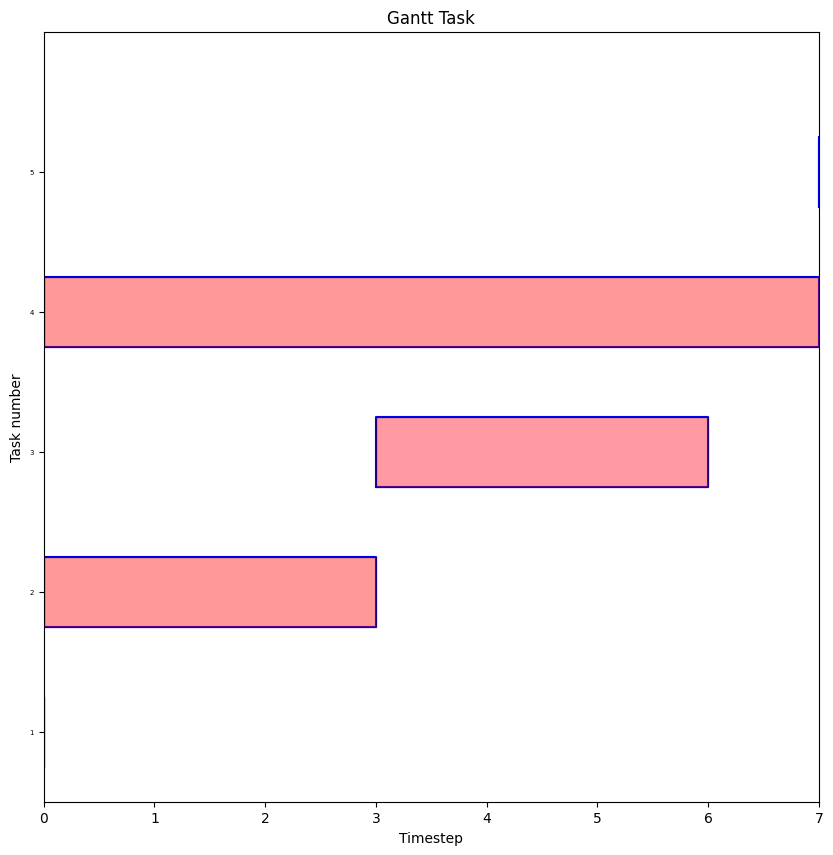

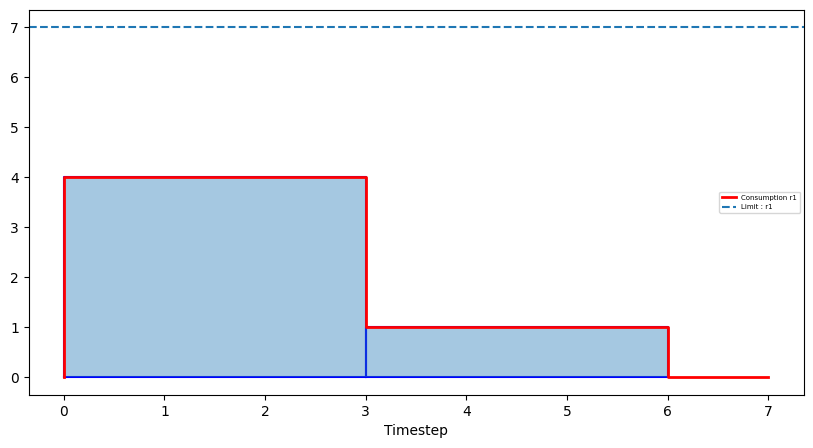

In [11]:
# Ploting solution
states = episode[0]
do_sol = from_last_state_to_solution(states[-1], domain)
# Each line of the plot is a task
fig_gantt = plot_task_gantt(do_sol.problem, do_sol)
# Plot resource consumption plot
fig_resource = plot_ressource_view(do_sol.problem, do_sol)

## Solving with combinatorial optimization 
Naïve graph search won't be efficient on classical sized instance. We developed a range of solvers based on operational research/discrete optimization methods to solve scheduling problems in skdecide.
[Discrete Optimization](https://github.com/airbus/discrete-optimization) library is the scheduling engine to solve scikit-decide scheduling domains. It implements an extensive API similar to scikit-decide for combinatorial optimization problems.

Besides scheduling it implements a wide range of domain (optimisation problems):
- knapsack, coloring, tsp, vrp, maximum independent set, facility location, rcpsp and variants.

All problems have a complete set of solving solvers available : 
- Mathematical programming methods (Milp with open source solver and Gurobi, CP with Ortools, minizinc models..)
- Local search and genetic algorithms
- Custom heuristics (queue scheduling etc)
API is flexible to combine different solver together, do (semi) automatic hyperparameter optimisation.

In [12]:
if len(get_data_available()) == 0:
    fetch_data_from_psplib()
file = [f for f in get_data_available() if "j1201_1.sm" in f][0]
rcpsp_domain = load_domain(file)
rcpsp_domain.set_inplace_environment(False)

### Solving with constraint programming solver
Current SoTa for scheduling is to use specific CP solver, sometimes using lazy clause generation (like ortools cpsat or chuffed among the open source solutions). \
```DOSolver``` is a scikit-decide Solver but uses in backend the CP model and solver present in discrete-optimization library.

In [14]:
# Solving with Constraint programming solver (Chuffed solver by default)
from discrete_optimization.rcpsp.solver.cpsat_solver import CPSatRCPSPSolver
minizinc_available = False
p = ParametersCP.default_cpsat()
p.time_limit = 5
solver = DOSolver(
        domain_factory=lambda: rcpsp_domain,
        method=SolvingMethod.CP if minizinc_available else None,
        do_solver_type=CPSatRCPSPSolver if not minizinc_available else None,
        policy_method_params=PolicyMethodParams(
            base_policy_method=BasePolicyMethod.FOLLOW_GANTT
        ),
        dict_params={"parameters_cp": p},
    )    
solver.solve()

In [15]:
episode = rollout(
    domain=rcpsp_domain,
    solver=solver,
    verbose=False,
    return_episodes=True,
    num_episodes=1,
)[0]
states = episode[0]
do_sol = from_last_state_to_solution(states[-1], rcpsp_domain)
print(do_sol.problem.evaluate(do_sol))

2024-05-29 18:00:49,683 | skdecide.utils | INFO | The goal was reached in episode 1.


{'makespan': 107.0, 'mean_resource_reserve': 0.0, 'constraint_penalty': 0.0}


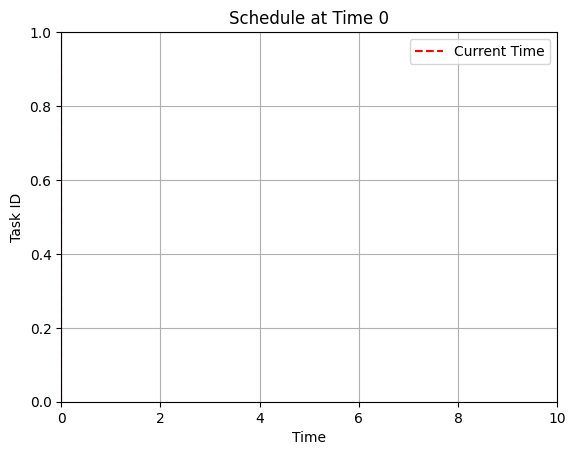

In [16]:
# Nice animated schedule ! 
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle


def plot_schedule(ax, state):
    ax.clear()
    ax.set_title(f"Schedule at Time {state.t}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Task ID")
    # Define colors for tasks
    colors = plt.cm.tab10.colors
    # Collect task IDs that are scheduled
    scheduled_tasks = [
        task_id
        for task_id, task in state.tasks_full_details.items()
        if task.start is not None
    ]
    # Plot each task as a rectangle
    for idx, (task_id, task) in enumerate(state.tasks_full_details.items()):
        if task.start is not None and task.end is not None:
            rect = Rectangle(
                (task.start, task_id - 0.4),
                task.end - task.start,
                0.8,
                color=colors[idx % 10],
                alpha=0.6,
            )
            ax.add_patch(rect)
            ax.text(
                (task.start + task.end) / 2,
                task_id,
                f"T{task_id}",
                ha="center",
                va="center",
                color="black",
                fontsize=8,
            )
        if task.start is not None and task.end is None:
            rect = Rectangle(
                (task.start, task_id - 0.4),
                state.t - task.start,
                0.8,
                color=colors[idx % 10],
                alpha=0.6,
                linestyle="dashed",
            )
            ax.add_patch(rect)
            ax.text(
                (task.start + state.t) / 2,
                task_id,
                f"T{task_id}",
                ha="center",
                va="center",
                color="black",
                fontsize=8,
            )

    # Plot the current time line
    ax.axvline(state.t, color="r", linestyle="--", label="Current Time")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, max(state.t + 1, 10))
    if scheduled_tasks:
        ax.set_ylim(min(scheduled_tasks) - 1.5, max(scheduled_tasks) + 1.5)


# Function to animate the plot
def animate(i):
    plot_schedule(ax, episode[0][i])


# Create the animation
fig, ax = plt.subplots()
ani = FuncAnimation(fig, animate, frames=len(episode[0]), repeat=False)
image_folder = os.path.join(os.getcwd(), "images/")
if not os.path.exists(image_folder):
  os.makedirs(image_folder)
gif_path = os.path.join(image_folder, "schedule_animation.gif")
ani.save(gif_path, writer=PillowWriter(fps=3))
# plt.show()

![Schedule Animation](images/schedule_animation.gif)

### Hyperparameter optimisation
Discrete Optimization solvers come with hyperparameters API opening the possibility to do hyperparam optimisation using the optuna library which is easily integrated to it.
Hyperparams of solver can be for examples : 
- temperature, cooling factor for metaheuristics such as Simulated annealing
- population size, mutation and crossover operators for genetic algorithms
- solver backend or model variants for CP approaches etc.

In [17]:
from discrete_optimization.generic_rcpsp_tools.large_neighborhood_search_scheduling import \
    LargeNeighborhoodSearchScheduling
from discrete_optimization.generic_rcpsp_tools.ls_solver import LS_RCPSP_Solver
from discrete_optimization.rcpsp.solver.cp_solvers import CP_RCPSP_MZN
from discrete_optimization.rcpsp.solver.rcpsp_ga_solver import GA_RCPSP_Solver

print("CP Solver hyperparams", CP_RCPSP_MZN.hyperparameters, "\n")
print("LNS hyperparams : ", LargeNeighborhoodSearchScheduling.hyperparameters, "\n")
print("Local search hyperparams : ", LS_RCPSP_Solver.hyperparameters, "\n")
print("Genetic algorithms hyperparams : ", GA_RCPSP_Solver.hyperparameters, "\n")

CP Solver hyperparams [EnumHyperparameter(name='cp_solver_name', default=<CPSolverName.CHUFFED: 0>, choices=[<CPSolverName.CHUFFED: 0>, <CPSolverName.GECODE: 1>, <CPSolverName.CPLEX: 2>, <CPSolverName.CPOPT: 3>, <CPSolverName.GUROBI: 4>, <CPSolverName.ORTOOLS: 5>, <CPSolverName.HIGHS: 6>])] 

LNS hyperparams :  [EnumHyperparameter(name='cp_solver_name', default=<CPSolverName.CHUFFED: 0>, choices=[<CPSolverName.CHUFFED: 0>, <CPSolverName.GECODE: 1>, <CPSolverName.CPLEX: 2>, <CPSolverName.CPOPT: 3>, <CPSolverName.GUROBI: 4>, <CPSolverName.ORTOOLS: 5>, <CPSolverName.HIGHS: 6>]), CategoricalHyperparameter(name='do_ls', default=False, choices=[True, False]), EnumHyperparameter(name='constraint_handler_type', default=<ConstraintHandlerType.MIX_SUBPROBLEMS: 0>, choices=[<ConstraintHandlerType.MIX_SUBPROBLEMS: 0>, <ConstraintHandlerType.SOLUTION_REPAIR: 1>]), FloatHyperparameter(name='fraction_subproblem', default=0.05, low=0.0, high=1.0), IntegerHyperparameter(name='nb_cut_part', default=10, 

In [18]:
# Script implementing the optuna study.
from rcpsp_domains.multi_solve_optuna import run_optuna_multisolve

In [19]:
#This takes several minutes.
do_hyperparams = False
if do_hyperparams:
    run_optuna_multisolve(rcpsp_domain)
clear_output()

In [20]:
import subprocess
import threading

from dash import Dash, html


# Function to run the Optuna dashboard
def run_dashboard():
    subprocess.run(["optuna-dashboard", "--port", "8081", "rcpsp_domains/optuna_journal_offline.log" if not do_hyperparams else "optuna-journal.log"])


# Start the dashboard server in a separate thread
thread = threading.Thread(target=run_dashboard)
thread.start()

In [21]:
# This cell should be ran a few seconds or tried a few times after running the previous cell in order for the dashboard to be displayed ! 
app = Dash(__name__)
# Define the layout of the app with an iframe to the Optuna dashboard
app.layout = html.Div(
    [
        html.Iframe(
            src="http://localhost:8081", style={"width": "100%", "height": "800px"}
        )
    ]
)
# Function to run the Dash app in the notebook
def run_app():
    app.run_server(mode="notebook")


# Run the app in the notebook
run_app()

## Reinforcement learning
As additional (ongoing) works, we introduce new domains for specific scheduling problems, more adapted for reinforcement learning solvers to be run on.
Those implementation are scheduling-variant specific, the one we will look is the RCPSP domain again. The environment is vectorized contrary to the generic scheduling domain of scikit-decide.

- states are ($nb_{task}$, 2) shape array, where for each task we store in states[i, 0] the binary value corresponding if the task has been scheduled or not, and in states[i,1] the starting time
- action are index of task to schedule next.

In [22]:
from discrete_optimization.rcpsp.rcpsp_parser import (get_data_available,
                                                      parse_file)
from rcpsp_domains.rcpsp_sk_domain import (ParamsDomainEncoding, RCPSPModel,
                                           RCPSPSGSDomain)

file = [f for f in get_data_available() if "j301_1.sm" in f][0]
model: RCPSPModel = parse_file(file)
domain_sk = RCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=False,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=30,
        use_additive_makespan_for_cost=True,
        nb_min_task_inserted=8,
        nb_max_task_inserted=25,
        filter_tasks=True,
        only_available_tasks=False,
    ),
)

In [23]:
# Some utils functions
def run_rollout(domain, solver=None, nb_rollout=100):
    makespans = []
    for i in range(1000):
        episodes = rollout(
            domain=domain,
            solver=solver,
            verbose=False,
            num_episodes=1,
            return_episodes=True,
        )
        if domain.state[-1, 0]:
            solution_rcpsp = RCPSPSolution(
                problem=model,
                rcpsp_schedule={
                    t: {
                        "start_time": domain.state[domain.task_to_index[t], 1],
                        "end_time": domain.state[domain.task_to_index[t], 1]
                        + domain.dur[domain.task_to_index[t]],
                    }
                    for t in model.tasks_list
                },
            )
            # print(model.evaluate(solution_rcpsp), model.satisfy(solution_rcpsp))
            makespans.append(domain_sk.state[-1, 1])
    return makespans


def compute_statistics(arr):
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a numpy array")
    statistics = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "min": np.min(arr),
        "max": np.max(arr),
        "25th percentile": np.percentile(arr, 25),
        "50th percentile": np.percentile(arr, 50),
        "75th percentile": np.percentile(arr, 75),
    }
    return statistics

### Random rollouts
Let's run random rollout on this domain.

In [24]:
makespans_random = run_rollout(domain_sk, solver=None, nb_rollout=100)
clear_output()

Stats with random policy  {'mean': 53.912, 'median': 53.0, 'min': 47, 'max': 64, '25th percentile': 51.0, '50th percentile': 53.0, '75th percentile': 56.0}


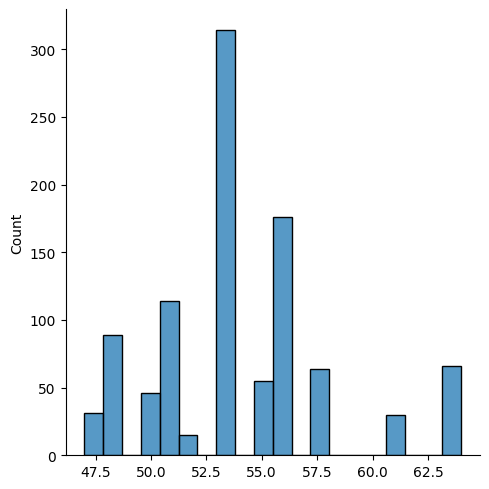

In [25]:
stats = compute_statistics(np.array(makespans_random))
print("Stats with random policy ", stats)
sns.displot(makespans_random, bins=20)

### Few words on RL solvers
In the next section we will test mainly 3 RL solvers, briefly explained here :

#### Proximal Policy Optimization (PPO)
- **Type**: Policy-based method.
- **Mechanism**: Utilizes a clipped surrogate objective to update policies, balancing exploration and exploitation.
- **Advantages**: 
  - More stable and reliable training compared to earlier policy gradient methods.
  - Suitable for both discrete and continuous action spaces.
- **Usage**: Popular in many reinforcement learning applications, including robotics and games.

#### Advantage Actor-Critic (A2C)
- **Type**: Actor-Critic method.
- **Mechanism**: Combines value-based and policy-based methods, using an actor to decide actions and a critic to evaluate them.
- **Advantages**: 
  - Efficient and relatively easy to implement.
  - Good balance between bias and variance, leading to more stable learning.
- **Usage**: Effective for various control problems and environments with continuous action spaces.

#### Deep Q-Network (DQN)
- **Type**: Value-based method.
- **Mechanism**: Uses deep neural networks to approximate the Q-value function, enabling handling of high-dimensional state spaces.
- **Advantages**: 
  - Demonstrated success in complex environments like Atari games.
  - Employs techniques like experience replay and target networks for stable training.
- **Usage**: Ideal for problems with discrete action spaces and where the state-action space can be effectively represented with deep learning.

### Solving the domain using stable baselines

In [26]:
from rcpsp_domains.rcpsp_sk_domain import RCPSPSGSDomain, records
from stable_baselines3 import A2C, DQN, PPO
# Here you can play with the core algorithm to be used. Empirically A2C works the best !
algo = A2C

records.clear()
domain_sk = RCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=True,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=1,
        use_additive_makespan_for_cost=False,
        nb_min_task_inserted=1,
        nb_max_task_inserted=None,
        filter_tasks=False,
        only_available_tasks=False,
    ),
)

solver_args = {
    "baselines_policy": "MlpPolicy",
    "learn_config": {"total_timesteps": 30000},
    "verbose": 0,
    "n_steps": 300,
    # "batch_size": 100
}
solver_args.update(
    {
        "policy_kwargs": dict(
            net_arch=[dict(pi=[256, 256, 128, 128], vf=[256, 256, 128, 128])]
        )
    }
)
solver_args["algo_class"] = algo
solver = StableBaseline(domain_factory=lambda: domain_sk, **solver_args)
solver.solve()
makespans_sb = run_rollout(domain_sk, solver=solver, nb_rollout=100)
clear_output()

Stats with A2C {'mean': 45.004, 'median': 45.0, 'min': 45, 'max': 47, '25th percentile': 45.0, '50th percentile': 45.0, '75th percentile': 45.0}


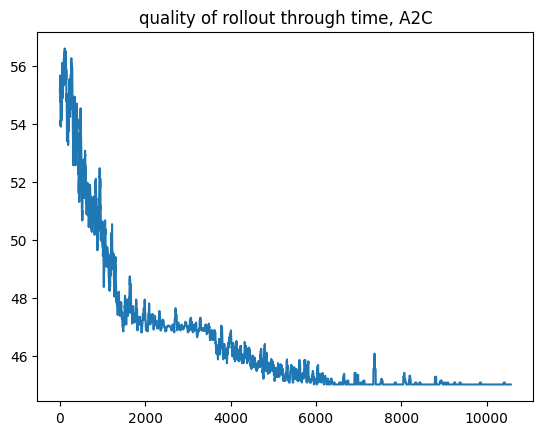

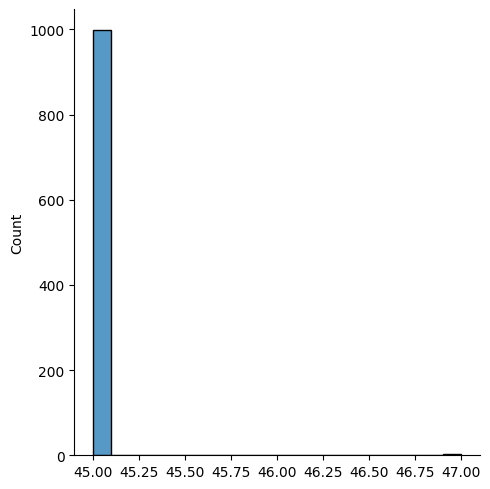

In [27]:
fig, ax = plt.subplots(1)
records_sb = np.array(records)
ax.plot(np.convolve(records_sb, np.ones(30) / 30, mode="valid"))
ax.set_title(f"quality of rollout through time, {algo.__name__}")
sns.displot(makespans_sb, bins=20)
print(f"Stats with {algo.__name__}", compute_statistics(np.array(makespans_sb)))
plt.show()

### DQN With RLLIB
Wrappers of RLLib implemented in scikit-decide hub can have the advantage of taking into account **filtered actions**, that is a usual pain point in Reinforcement learning. \
Using this solver will use the fact that available actions at a given state should only be task that are not yet scheduled. \
[Note : To the contrary, other solvers we tested were discarding these filtered action, therefore the implementation was handling useless action by putting some penalty cost on the transition]



In [28]:
from ray.rllib.algorithms.dqn import DQN
from ray.rllib.algorithms.ppo import PPO
from rcpsp_domains.rcpsp_sk_domain import RCPSPSGSDomain, records
records.clear()
from skdecide.hub.solver.ray_rllib import RayRLlib
algo = DQN
domain_sk = RCPSPSGSDomain(
        model,
        params_domain_encoding=ParamsDomainEncoding(
            return_times_in_state=False,
            return_scheduled_in_state=True,
            use_cpm_for_cost=True,
            terminate_when_already_schedule=False,
            dummy_cost_when_already_schedule=30,
            use_additive_makespan_for_cost=False,
            nb_min_task_inserted=None,
            nb_max_task_inserted=25,
            filter_tasks=True,
            only_available_tasks=False,
        ),
    )
ac = algo.get_default_config()
ac.lr = 5e-3
solver = RayRLlib(domain_factory=lambda: domain_sk.shallow_copy(), 
                  algo_class=algo,
                  config=ac,
                  train_iterations=10)
assert RayRLlib.check_domain(domain_sk)
solver.solve()
makespan_rllib = run_rollout(domain_sk, solver=solver, nb_rollout=100)
records_rllib = np.array(records)
clear_output()

Stats with DQN {'mean': 52.789, 'median': 53.0, 'min': 43, 'max': 62, '25th percentile': 53.0, '50th percentile': 53.0, '75th percentile': 53.0}


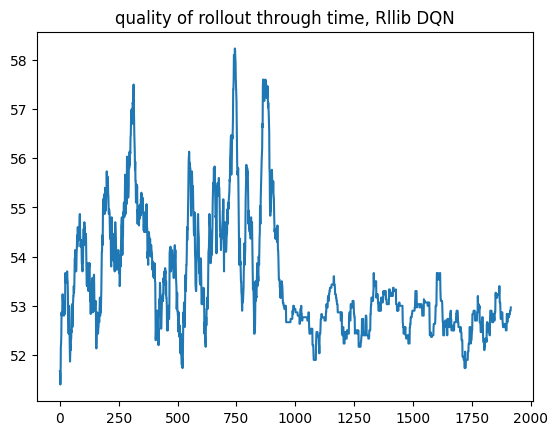

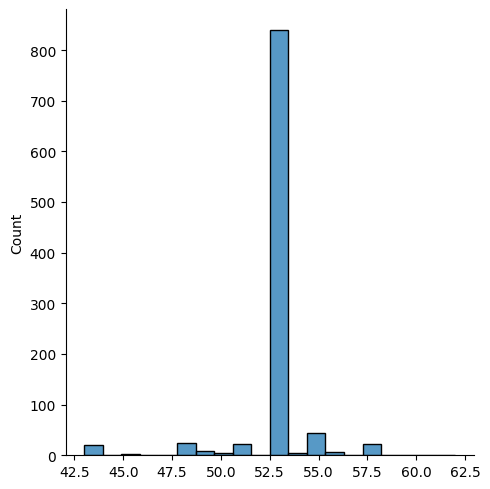

In [29]:
fig, ax = plt.subplots(1)
records_rllib = np.array(records)
ax.plot(np.convolve(records_rllib, np.ones(30) / 30, mode="valid"))
ax.set_title(f"quality of rollout through time, Rllib {algo.__name__}")
sns.displot(makespan_rllib, bins=20)
print(f"Stats with {algo.__name__}", compute_statistics(np.array(makespan_rllib)))
plt.show()

### Bonus words on RL

#### Stochastic RCPSP : 
RL is particularly suited for stochastic domains, ```StochasticRCPSPSGSDomain``` is a stochastic domain where duration are sampled from a distribution. \
The state space is : 
-an array of shape ($nb_{tasks}$, 3), where we store the fact that a task is scheduled, along with start and sampled end times. \
RL algorithms can be experimented on this domain (implemented in ```rcpsp_domains.stochastic_rcpsp_sk_domain``` module)

#### Local search domain for RCPSP : 
An alternative domain implementation for RCPSP is to consider local moves/mutation of the schedules as the available actions for a RL domain. \
In our playground implementation, actions are local moves consisting in reverting a subpart of the permutation of tasks representing the solution. This is similar to the [2-opt](https://en.wikipedia.org/wiki/2-opt) mutation for traveling salesman problem.\
Implemented in ```rcpsp_domains.rcpsp_sk_domain_local_search```.

#### Direct permutation optimisation :
We can also use RL to optimize directly the full permutation, the actions here are a $nb_{tasks}$ floating or integer array. [We use np.argsort to compute a permutation of task that is then used to build an rcpsp solution]\
Implemented in ```rcpsp_domains.rcpsp_sk_domain_local_search```.

Example of uses are available in the more [complete version of this notebook](Scheduling%20tutorial.ipynb)

## Conclusion

In this tutorial you've been introduced to : 
- the scheduling API of scikit-decide
- its automatic implementation of scheduling domain from simple data definition of scheduling problem
- use of scikit-decide solver (planning, discrete optimization, RL) to solve scheduling problems
- discrete optimization library easing the implementation of mathematical programming, metaheuristic solver and hyperparameter optimisation.

The RL works is notably open to more research with inclusion of GNN like [wheatley](https://github.com/jolibrain/wheatley) or more efficient RL formulation [Jumanji](https://github.com/instadeepai/jumanji)